# Sprint 深層学習スクラッチ ニューラルネットワーク

## Sprintの目的
スクラッチを通してニューラルネットワークの基礎を理解する
画像データの扱い方を知る

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from keras.datasets import mnist

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: F

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

### データセットの確認

In [3]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
#print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8


### 平滑化

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

### 画像データの可視化

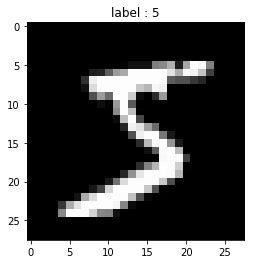

In [5]:
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

#### 《発展的話題》

### 前処理

In [6]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [7]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [8]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print("X_train.shape =", X_train_.shape) # (48000, 784)
print("X_val.shape =", X_val.shape) # (12000, 784)
print("y_train.shape =", y_train_.shape) # (48000, 784)
print("y_val.shape =", y_val.shape) # (12000, 784)

X_train.shape = (48000, 784)
X_val.shape = (12000, 784)
y_train.shape = (48000, 10)
y_val.shape = (12000, 10)


## ニューラルネットワークスクラッチ

In [24]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """

    def __init__(self, num_epoch=10, lr=0.01, batch_size=20, n_features=784, n_nodes1=400, n_nodes2=200, n_output=10, verbose=True):
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose
        
        self.batch_size = batch_size # バッチサイズ
        self.n_features = n_features # 特徴量の数
        self.n_nodes1 = n_nodes1 # 1層目のノード数
        self.n_nodes2 = n_nodes2 # 2層目のノード数
        self.n_output = n_output # 出力のクラス数（3層目のノード数）
        
        self.w1 = None
        self.w2 = None
        self.w3 = None
        self.A1 = None
        self.A2 = None
        self.A3 = None
        self.Z1 = None
        self.Z2 = None
        self.Z3 = None
        self.loss = None
        self.val_loss = None
        
        self.a1 = []
        self.a2 = []
        self.b = []

    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        self.val_enable = False
        if X_val is not None:
            self.val_enable = True
        
        self.w1 = self.w_init(self.n_features, self.n_nodes1)
        self.w2 = self.w_init(self.n_nodes1, self.n_nodes2)
        self.w3 = self.w_init(self.n_nodes2, self.n_output)
        
        self.B1 = self.w_init(1, self.w1.shape[1])
        self.B2 = self.w_init(1, self.w2.shape[1])
        self.B3 = self.w_init(1, self.w3.shape[1])
        
        self.loss = []
        self.val_loss = []
        for _ in range(self.num_epoch):
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            for mini_X, mini_y in get_mini_batch:
                self.forward_propagation(mini_X)
                self.back_propagation(mini_X, mini_y)
            """
            self.forward_propagation(X)
            self.back_propagation(X, y)
            """
            
            self.loss.append(self.loss_func(y, self.forward_propagation(X)))
            if self.val_enable:
                self.val_loss.append(self.loss_func(y_val, self.forward_propagation(X_val)))
        
        print()
        if self.verbose:
            self.learning_curve()
            print()

    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples)
            推定結果
        """
        return np.argmax(self.forward_propagation(X), axis=1)
    
    def w_init(self, n_features, n_nodes):
        sigma = 0.01 # ガウス分布の標準偏差
        w = sigma * np.random.randn(n_features, n_nodes)
        return w
    
    def forward_propagation(self, X):
        f = self.tanh
        self.A1 = X@self.w1 + self.B1
        self.Z1 = f(self.A1)
        self.A2 = self.Z1@self.w2 + self.B2
        self.Z2 = f(self.A2)
        self.A3 = self.Z2@self.w3 + self.B3
        self.Z3 = self.softmax(self.A3)
        return self.Z3
    
    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X))
    
    def tanh(self, X):
        return np.tanh(X)
    
    def softmax(self, X):
        X = X - np.max(X)
        return np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
    
    def loss_func(self, y_true, z):
        """
        y_true : (n_samples, n_output)
        z : (n_samples, n_output)
        """
        return (-1)*np.average(np.sum(y_true*np.log(z), axis=1))
    
    def back_propagation(self, X, y_true):
        """
        y_true : (n_samples, n_output)
        """
        """
        L_A3 = np.average(self.Z3 - y_true, axis=0)
        L_B3 = L_A3
        L_w3 = np.average(self.Z2, axis=0).reshape(-1,1)*L_A3
        L_Z2 = L_A3@self.w3.T
        
        L_A2 = L_Z2 * (1 - (self.tanh(np.average(self.A2, axis=0)))**2)
        L_B2 = L_A2
        L_w2 = np.average(self.Z1, axis=0).reshape(-1,1)*L_A2
        L_Z1 = L_A2@self.w2.T
        
        L_A1 = L_Z1 * (1 - (self.tanh(np.average(self.A1, axis=0)))**2)
        L_B1 = L_A1
        L_w1 = np.average(X, axis=0).reshape(-1,1)*L_A1
        """
        L_A3 = self.Z3 - y_true # (batch_size, 10)
        L_B3 = np.sum(L_A3, axis=0) # (10,)
        L_w3 = self.Z2.T@L_A3 # (n_nodes2, 10)
        L_Z2 = L_A3@self.w3.T # (n_nodes1, n_nodes2)
        
        L_A2 = L_Z2 * (1 - (self.tanh(np.average(self.A2, axis=0)))**2)
        L_B2 = np.sum(L_A2, axis=0)
        L_w2 = self.Z1.T@L_A2
        L_Z1 = L_A2@self.w2.T
        
        L_A1 = L_Z1 * (1 - (self.tanh(np.average(self.A1, axis=0)))**2)
        L_B1 = np.sum(L_A1, axis=0)
        L_w1 = X.T@L_A1
        
        self.w1 -= self.lr*L_w1
        self.w2 -= self.lr*L_w2
        self.w3 -= self.lr*L_w3
        
        self.B1 -= self.lr*L_B1
        self.B2 -= self.lr*L_B2
        self.B3 -= self.lr*L_B3
        
        return
    
    def learning_curve(self):
        plt.title("model loss")
        plt.xlabel("num_epoch")
        plt.ylabel("loss")
        plt.plot(np.arange(self.num_epoch), self.loss, label="train_loss")
        if self.val_enable:
            plt.plot(np.arange(self.num_epoch), self.val_loss, label="val_loss")
        plt.legend()
        plt.show()

### ミニバッチ処理

In [10]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [11]:
get_mini_batch = GetMiniBatch(X_train_, y_train_, batch_size=20)
#print(len(get_mini_batch)) # 2400
#print(get_mini_batch[5]) # 5番目のミニバッチが取得できる
for mini_X_train, mini_y_train in get_mini_batch:
    # このfor文内でミニバッチが使える
    pass

## 学習

## 【問題1】重みの初期値を決めるコードの作成

ScratchSimpleNeuralNetrowkClassifier クラスに w_init メソッドを追加  
ScratchSimpleNeuralNetrowkClassifier クラスの fit メソッドを変更  

## 【問題2】フォワードプロパゲーションの実装

ScratchSimpleNeuralNetrowkClassifier クラスに forward_propagation メソッドを追加  
ScratchSimpleNeuralNetrowkClassifier クラスの fit メソッドを変更  

### 活性化関数（フォワードプロバゲーション）

ScratchSimpleNeuralNetrowkClassifier クラスに sigmoid メソッド、 tanh メソッドを追加

### ソフトマックス関数

ScratchSimpleNeuralNetrowkClassifier クラスに softmax メソッドを追加

## 【問題3】交差エントロピー誤差の実装

ScratchSimpleNeuralNetrowkClassifier クラスに loss_func メソッドを追加

## 【問題4】バックプロパゲーションの実装

ScratchSimpleNeuralNetrowkClassifier クラスに back_propagation メソッドを追加  
ScratchSimpleNeuralNetrowkClassifier クラスの fit メソッドを変更  

## 【問題5】推定

ScratchSimpleNeuralNetrowkClassifier クラスの predict メソッドを変更  

## 【問題6】学習と推定

In [12]:
def evaluate(y_true, y_pred):
    print("accuracy =", accuracy_score(y_true, y_pred))
    print("precision =", precision_score(y_true, y_pred, average='macro'))
    print("recall =", recall_score(y_true, y_pred, average='macro'))
    print("f1 =", f1_score(y_true, y_pred, average='macro'))
    print(confusion_matrix(y_true, y_pred))

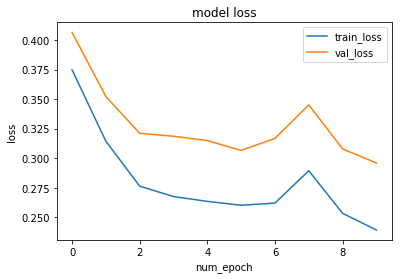

In [25]:
scratch_snn = ScratchSimpleNeuralNetrowkClassifier(num_epoch=10, lr=1e-2, verbose=True)
scratch_snn.fit(X_train_, y_train_, X_val, y_val)
y_pred = scratch_snn.predict(X_test)

In [26]:
print(y_pred)
print(y_pred.shape)

[7 2 1 ... 4 5 6]
(10000,)


In [27]:
evaluate(y_test, y_pred)

accuracy = 0.9275
precision = 0.9287653784519796
recall = 0.9261176228510095
f1 = 0.9263453995114894
[[ 944    0    1    3    0    3   23    1    5    0]
 [   0 1099    8    6    0    1    4    2   15    0]
 [   9    0  958   21    4    0   17    4   18    1]
 [   5    0   11  936    1   19    2    7   26    3]
 [   1    0   19    1  912    1   18    4   10   16]
 [  10    4   10   59    7  732   30    2   34    4]
 [   4    1    4    2    1    4  939    1    2    0]
 [   1    5   28   12    4    0    1  959    5   13]
 [   4    4    8   25    5    3   15    5  905    0]
 [   7    5    5   19   41    4    2   18   17  891]]


In [28]:
evaluate(np.argmax(y_val, axis=1), scratch_snn.predict(X_val))

accuracy = 0.921
precision = 0.9221115570969414
recall = 0.9190737802481523
f1 = 0.9196203902882859
[[1123    0    4    4    1    3   28    2   18    0]
 [   0 1326   18    7    2    1    2    3   23    3]
 [   7    4 1071   22    4    2   13    7   27    1]
 [   5    4   21 1121    1   24   10    6   33    3]
 [   2    4   33    1 1008    2   22    5    9   25]
 [  15    2   11   56   10  864   38    1   49    5]
 [   2    0   10    0    3    4 1164    0    3    0]
 [   1    5   20    9    7    0    0 1219    7   16]
 [   6    9   15   34    8    9   25    0 1100    6]
 [   1    7    8   16   49    4    2   30   29 1056]]


In [29]:
evaluate(np.argmax(y_train_, axis=1), scratch_snn.predict(X_train_))

accuracy = 0.9319583333333333
precision = 0.9329383238713067
recall = 0.9307736175858098
f1 = 0.9310094024405716
[[4586    1   13   11    6   15   74    2   31    1]
 [   1 5171   56   25    6    7    6   10   65   10]
 [  28    9 4526   77   17    5   45   18   68    7]
 [   7    9   77 4534    4   77   17   24  137   17]
 [   1    9   99    7 4369    7   82   12   43  102]
 [  43   16   39  214   27 3688  131   11  186   15]
 [  10    3   28    1    5   12 4661    0   11    1]
 [   6   12  102   33   20    2    2 4724   25   55]
 [  20   42   51  100   19   20   63    5 4309   10]
 [  19   10   50   82  190   15    4  102  109 4166]]


## 【問題7】学習曲線のプロット

ScratchSimpleNeuralNetrowkClassifier クラスに learning_curve メソッドを追加し、 fit メソッドに書き加えた。  

## 【問題8】（アドバンス課題）誤分類の確認

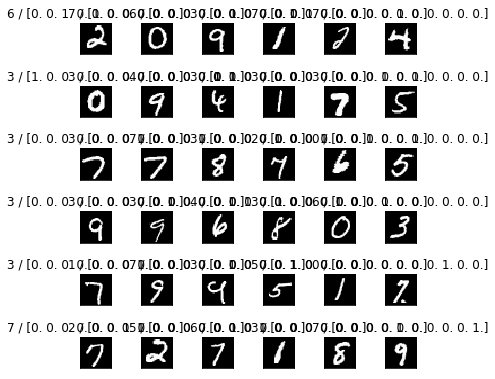

In [19]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証用データの正解ラベル(n_samples,)
X_val : 検証用データの特徴量（n_samples, n_features)
"""

num = 36 # いくつ表示するか

true_false = y_pred==y_test
false_list = np.where(true_false==False)[0].astype(np.int)

if len(false_list) < num:
    num = len(false_list)

fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')